# Telecom Churn - Case Study

## Business Problem Overview

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.

 

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

 

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

In [82]:
import sys
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -mpip install statsmodels
!{sys.executable} -mpip install imbalanced-learn

  Using cached https://files.pythonhosted.org/packages/c8/81/8db4d87b03b998fda7c6f835d807c9ae4e3b141f978597b8d7f31600be15/imbalanced_learn-0.7.0-py3-none-any.whl


In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import warnings
warnings.filterwarnings('ignore')

# show multiple outputs in jupyter cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from datetime import datetime

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score

### Data Preparation

In [11]:
telecom_churn_data = pd.read_csv("telecom_churn_data.csv")
telecom_churn_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [12]:
telecom_churn_data.shape

(99999, 226)

In [13]:
telecom_churn_data.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,...,99999.000000,25153.000000,25571.000000,26339.000000,25922.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,7.001207e+09,109.0,0.0,0.0,0.0,282.987358,278.536648,279.154731,261.645069,132.395875,...,0.084581,0.914404,0.908764,0.890808,0.860968,1219.854749,68.170248,66.839062,60.021204,3.299373
std,6.956694e+05,0.0,0.0,0.0,0.0,328.439770,338.156291,344.474791,341.998630,297.207406,...,0.650457,0.279772,0.287950,0.311885,0.345987,954.733842,267.580450,271.201856,253.938223,32.408353
min,7.000000e+09,109.0,0.0,0.0,0.0,-2258.709000,-2014.045000,-945.808000,-1899.505000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000606e+09,109.0,0.0,0.0,0.0,93.411500,86.980500,84.126000,62.685000,7.380000,...,0.000000,1.000000,1.000000,1.000000,1.000000,467.000000,0.000000,0.000000,0.000000,0.000000
50%,7.001205e+09,109.0,0.0,0.0,0.0,197.704000,191.640000,192.080000,176.849000,34.310000,...,0.000000,1.000000,1.000000,1.000000,1.000000,863.000000,0.000000,0.000000,0.000000,0.000000
75%,7.001812e+09,109.0,0.0,0.0,0.0,371.060000,365.344500,369.370500,353.466500,118.740000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1807.500000,0.000000,0.000000,0.000000,0.000000
max,7.002411e+09,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,38805.617000,7376.710000,...,49.000000,1.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.210000,2618.570000


In [14]:
telecom_churn_data.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

#### Filter High Value Customers

In the Indian and the southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

 
As mentioned above, you need to predict churn only for the high-value customers. Define high-value customers as follows: **Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).**

 

After filtering the high-value customers, you should get about 29.9k rows.



In [15]:
telecom_churn_data['total_rech_data_amt_6'] = telecom_churn_data['av_rech_amt_data_6'] * telecom_churn_data['total_rech_data_6']
telecom_churn_data['total_rech_data_amt_7'] = telecom_churn_data['av_rech_amt_data_7'] * telecom_churn_data['total_rech_data_7']

# drop columns av_rech_amt_data_x,total_rech_data_x (x = 6/7/8)
telecom_churn_data.drop(['total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9',
'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9'],axis = 1,inplace = True)

# Avg recharge done = total amount spend would be the sum of total data recharge done & total call/sms recharges
telecom_av_rech_6n7 = (telecom_churn_data['total_rech_amt_6'].fillna(0) 
+ telecom_churn_data['total_rech_amt_7'].fillna(0) 
+ telecom_churn_data['total_rech_data_amt_6'].fillna(0) 
+ telecom_churn_data['total_rech_data_amt_7'].fillna(0))/2

# take 70 percentile of the calculated average amount
percentile_70_6n7 = np.percentile(telecom_av_rech_6n7, 70.0)
print("70 percentile is : ", percentile_70_6n7)

# fitler the given data set based on 70th percentile
telecom_hv_cust = telecom_churn_data[telecom_av_rech_6n7 >= percentile_70_6n7]

print("Dimensions of the filtered dataset:",telecom_hv_cust.shape)

70 percentile is :  478.0
Dimensions of the filtered dataset: (30001, 220)


#### Churn Metric

In [16]:
# lets introduce a new column "churn", values would be either 1 (churn) or 0 (non-churn)
# we will calculate churn/non-churn based on the usage as mentioned in the problem statement
telecom_hv_cust['churn'] = np.where(telecom_hv_cust[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1) == 0, 1,0)
telecom_hv_cust.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_data_amt_6,total_rech_data_amt_7,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,1.0,NaN,968,30.40,0.00,101.20,3.58,252.0,252.0,1
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,NaN,NaN,802,57.74,19.38,18.74,0.00,NaN,NaN,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,1.0,NaN,315,21.03,910.65,122.16,0.00,NaN,354.0,0
21,7002124215,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,514.453,...,NaN,NaN,720,0.00,0.00,0.00,0.00,NaN,NaN,0
23,7000887461,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,74.350,...,1.0,1.0,604,40.45,51.86,0.00,0.00,NaN,712.0,0


In [17]:
# churn vs non churn percentage
telecom_hv_cust['churn'].value_counts()/len(telecom_hv_cust)*100

0    91.863605
1     8.136395
Name: churn, dtype: float64

91% of the customers do not churn. This also points us to class imbalance.

In [18]:
cols = [c for c in telecom_hv_cust.columns if c[-2:] == '_9']
telecom_hv_cust.drop(axis=1, columns =cols, inplace=True)
cols

['last_date_of_month_9',
 'arpu_9',
 'onnet_mou_9',
 'offnet_mou_9',
 'roam_ic_mou_9',
 'roam_og_mou_9',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_9',
 'loc_og_mou_9',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_9',
 'std_og_t2c_mou_9',
 'std_og_mou_9',
 'isd_og_mou_9',
 'spl_og_mou_9',
 'og_others_9',
 'total_og_mou_9',
 'loc_ic_t2t_mou_9',
 'loc_ic_t2m_mou_9',
 'loc_ic_t2f_mou_9',
 'loc_ic_mou_9',
 'std_ic_t2t_mou_9',
 'std_ic_t2m_mou_9',
 'std_ic_t2f_mou_9',
 'std_ic_t2o_mou_9',
 'std_ic_mou_9',
 'total_ic_mou_9',
 'spl_ic_mou_9',
 'isd_ic_mou_9',
 'ic_others_9',
 'total_rech_num_9',
 'total_rech_amt_9',
 'max_rech_amt_9',
 'date_of_last_rech_9',
 'last_day_rch_amt_9',
 'date_of_last_rech_data_9',
 'max_rech_data_9',
 'count_rech_2g_9',
 'count_rech_3g_9',
 'vol_2g_mb_9',
 'vol_3g_mb_9',
 'arpu_3g_9',
 'arpu_2g_9',
 'night_pck_user_9',
 'monthly_2g_9',
 'sachet_2g_9',
 'monthly_3g_9',
 'sachet_3g_9',
 'fb_user_9']

In [19]:
# lets check the columns with no variance in their values and drop such columns
for i in telecom_hv_cust.columns:
    if telecom_hv_cust[i].nunique() == 1:
        print("\nColumn",i,"has no variance and contains only", telecom_hv_cust[i].nunique(),"unique value")
        print("Dropping the column",i)
        telecom_hv_cust.drop(i,axis=1,inplace = True)

print("\nDimension of the updated dataset:",telecom_hv_cust.shape)


Column circle_id has no variance and contains only 1 unique value
Dropping the column circle_id

Column loc_og_t2o_mou has no variance and contains only 1 unique value
Dropping the column loc_og_t2o_mou

Column std_og_t2o_mou has no variance and contains only 1 unique value
Dropping the column std_og_t2o_mou

Column loc_ic_t2o_mou has no variance and contains only 1 unique value
Dropping the column loc_ic_t2o_mou

Column last_date_of_month_6 has no variance and contains only 1 unique value
Dropping the column last_date_of_month_6

Column last_date_of_month_7 has no variance and contains only 1 unique value
Dropping the column last_date_of_month_7

Column last_date_of_month_8 has no variance and contains only 1 unique value
Dropping the column last_date_of_month_8

Column std_og_t2c_mou_6 has no variance and contains only 1 unique value
Dropping the column std_og_t2c_mou_6

Column std_og_t2c_mou_7 has no variance and contains only 1 unique value
Dropping the column std_og_t2c_mou_7

Co

In [20]:
# lets check the null values present in the dataset
(telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)).sort_values(ascending = False)

arpu_3g_8                   46.825106
fb_user_8                   46.825106
date_of_last_rech_data_8    46.825106
count_rech_3g_8             46.825106
arpu_2g_8                   46.825106
                              ...    
last_day_rch_amt_6           0.000000
last_day_rch_amt_7           0.000000
last_day_rch_amt_8           0.000000
vol_2g_mb_6                  0.000000
mobile_number                0.000000
Length: 156, dtype: float64

In [21]:
# Drop Columns with > 30% of missing values except 9th Month's columns
cols = telecom_hv_cust.columns
telecom_null_perc = telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)
telecom_null_df = pd.DataFrame({'col_name': cols,
                                 'perc_null': telecom_null_perc})

drop_cols = telecom_null_df.loc[(telecom_null_df["col_name"].str.contains('_9')==False) & (telecom_null_df["perc_null"] > 30.0)]["col_name"]
print("list of columns dropped:",drop_cols)

# lets drop these columns
telecom_hv_cust.drop(drop_cols, axis=1,inplace = True)
telecom_hv_cust.shape

list of columns dropped: date_of_last_rech_data_6    date_of_last_rech_data_6
date_of_last_rech_data_7    date_of_last_rech_data_7
date_of_last_rech_data_8    date_of_last_rech_data_8
max_rech_data_6                      max_rech_data_6
max_rech_data_7                      max_rech_data_7
max_rech_data_8                      max_rech_data_8
count_rech_2g_6                      count_rech_2g_6
count_rech_2g_7                      count_rech_2g_7
count_rech_2g_8                      count_rech_2g_8
count_rech_3g_6                      count_rech_3g_6
count_rech_3g_7                      count_rech_3g_7
count_rech_3g_8                      count_rech_3g_8
arpu_3g_6                                  arpu_3g_6
arpu_3g_7                                  arpu_3g_7
arpu_3g_8                                  arpu_3g_8
arpu_2g_6                                  arpu_2g_6
arpu_2g_7                                  arpu_2g_7
arpu_2g_8                                  arpu_2g_8
night_pck_user_6     

(30001, 130)

In [22]:
# lets check for columns that can be changed to integers, floats or date types
object_col_data = telecom_hv_cust.select_dtypes(include=['object'])
print(object_col_data.iloc[0])

# observation : all the columns below can be converted to date type

date_of_last_rech_6    6/21/2014
date_of_last_rech_7    7/16/2014
date_of_last_rech_8     8/8/2014
Name: 0, dtype: object


In [23]:
# convert to datetime
for col in object_col_data.columns:
    telecom_hv_cust[col] = pd.to_datetime(telecom_hv_cust[col])

In [24]:
telecom_hv_cust['date_of_last_rech_6'].isnull().sum()
telecom_hv_cust['date_of_last_rech_6'].dropna(inplace=True)

73

In [25]:
telecom_hv_cust["days_since_last_rech"] = telecom_hv_cust[["date_of_last_rech_6", "date_of_last_rech_7", "date_of_last_rech_8"]].max(axis=1)
telecom_hv_cust['days_since_last_rech'] = datetime(2014, 9, 1) - telecom_hv_cust['days_since_last_rech']
telecom_hv_cust['days_since_last_rech'] = telecom_hv_cust['days_since_last_rech'].apply(lambda x: x.days)
telecom_hv_cust.loc[:,'date_of_last_rech_8':'days_since_last_rech']

,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn,days_since_last_rech
0,2014-08-08,252,252,252,30.13,1.32,5.75,83.57,150.76,109.61,...,0,0,0,968,30.40,0.00,101.20,3.58,1,24
7,2014-08-26,0,0,779,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,802,57.74,19.38,18.74,0.00,1,6
8,2014-08-30,50,0,10,0.00,356.00,0.03,0.00,750.95,11.94,...,0,0,0,315,21.03,910.65,122.16,0.00,0,2
21,2014-08-31,30,20,50,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,720,0.00,0.00,0.00,0.00,0,1
23,2014-08-24,0,179,0,0.00,0.48,0.01,0.00,599.09,1009.92,...,0,0,1,604,40.45,51.86,0.00,0.00,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99981,2014-08-27,252,0,130,54.81,101.02,112.07,692.72,596.91,1012.70,...,0,0,0,473,1100.43,619.59,668.05,0.33,0,5
99984,2014-08-27,0,25,25,1248.50,725.05,202.22,0.00,0.00,0.00,...,0,0,0,820,0.00,0.00,0.00,0.00,0,5
99986,2014-08-18,550,786,0,34.28,16.41,6.47,736.01,1129.34,926.78,...,0,0,0,2696,497.45,598.67,604.08,0.00,0,14
99988,2014-08-29,50,50,50,0.00,0.00,0.79,0.00,13.56,678.74,...,0,0,0,328,104.73,0.00,0.00,0.00,0,3


In [26]:
cols = [c for c in telecom_hv_cust.columns if "date_of_last_rech" in c]
telecom_hv_cust.drop(axis=1, columns =cols, inplace=True)
cols

['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']

### EDA

In [27]:
corr = telecom_hv_cust.corr()
corr

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn,days_since_last_rech
mobile_number,1.000000,0.033944,0.029496,0.034570,0.008389,0.003247,0.004858,0.019866,0.009881,0.015685,...,-0.014893,-0.013193,-0.009693,0.315694,-0.032058,-0.028015,-0.037881,-0.007521,-0.030100,0.008998
arpu_6,0.033944,1.000000,0.671732,0.612617,0.339552,0.221413,0.197928,0.507166,0.348575,0.303135,...,-0.002555,-0.025233,-0.017509,0.041451,0.058547,0.055172,0.112462,0.045053,0.067624,-0.020704
arpu_7,0.029496,0.671732,1.000000,0.759858,0.212484,0.317217,0.266236,0.354724,0.487069,0.392486,...,-0.027247,0.010861,0.000907,0.031506,0.083801,0.102527,0.055324,0.059261,-0.012789,-0.125979
arpu_8,0.034570,0.612617,0.759858,1.000000,0.150846,0.230248,0.337872,0.279629,0.374035,0.514985,...,-0.022256,-0.002160,0.045430,0.070789,0.146710,0.085501,0.073855,0.104992,-0.160911,-0.212882
onnet_mou_6,0.008389,0.339552,0.212484,0.150846,1.000000,0.762120,0.643175,0.083203,0.033268,0.035279,...,-0.053936,-0.046787,-0.045521,-0.051554,-0.106360,-0.112100,-0.102942,-0.034351,0.080303,-0.059177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
jul_vbc_3g,-0.028015,0.055172,0.102527,0.085501,-0.112100,-0.109663,-0.092710,-0.103274,-0.104810,-0.078788,...,0.066176,0.064155,0.049845,0.023823,0.697279,1.000000,0.667316,0.149139,-0.055555,0.025684
jun_vbc_3g,-0.037881,0.112462,0.055324,0.073855,-0.102942,-0.107852,-0.085046,-0.087686,-0.100031,-0.073046,...,0.064981,0.052005,0.046155,0.017251,0.577860,0.667316,1.000000,0.138163,-0.031014,0.051189
sep_vbc_3g,-0.007521,0.045053,0.059261,0.104992,-0.034351,-0.034045,-0.029260,-0.019681,-0.021008,-0.011529,...,0.060125,0.048547,0.052337,0.012169,0.193733,0.149139,0.138163,1.000000,-0.043793,-0.027024
churn,-0.030100,0.067624,-0.012789,-0.160911,0.080303,0.028304,-0.040196,0.073142,0.018884,-0.072799,...,0.010498,-0.001713,-0.037132,-0.108276,-0.090694,-0.055555,-0.031014,-0.043793,1.000000,0.300582


<Figure size 1440x720 with 0 Axes>

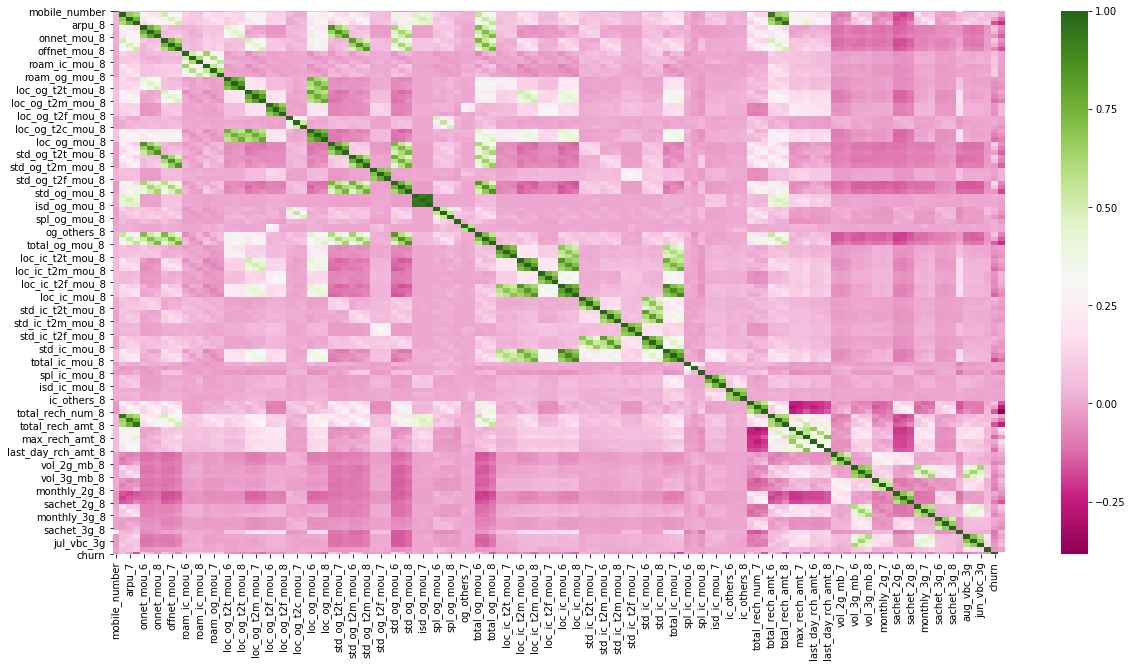

In [28]:
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(corr, cmap="PiYG")

We will remove highly correlated features for two reasons - 

- PCA needs non-correlated features to perform well
- Decision Trees are immune to multicollinearity anyways.

In [29]:
telecom_hv_cust.shape

(30001, 128)

## To Do -  

- We have to do PCA and Xgboost
- We have to check if data is imbalanced, we would then need to do oversampling to balance it

In [30]:
telecom_hv_cust.isnull().sum().sort_values(ascending = False)

loc_ic_t2f_mou_8      1174
std_og_t2f_mou_8      1174
spl_ic_mou_8          1174
ic_others_8           1174
std_og_t2m_mou_8      1174
                      ... 
last_day_rch_amt_6       0
last_day_rch_amt_7       0
last_day_rch_amt_8       0
vol_2g_mb_6              0
mobile_number            0
Length: 128, dtype: int64

In [31]:
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_ic_t2f_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_ic_t2m_mou_7'])]

## Data Preparation

### Splitting Data into Training and Test Sets

In [32]:
from sklearn.model_selection import train_test_split

# Putting feature variable to X
X = telecom_hv_cust.drop(['churn','mobile_number'],axis=1)

# Putting response variable to y
y = telecom_hv_cust['churn']

y.head()

7     1
8     0
21    0
23    0
33    0
Name: churn, dtype: int32

In [33]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

## Model Building
Let's start by splitting our data into a training set and a test set.

### Running Your First Training Model

In [36]:
import statsmodels.api as sm

In [37]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                19952
Model:                            GLM   Df Residuals:                    19825
Model Family:                Binomial   Df Model:                          126
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3003.7
Date:                Fri, 30 Oct 2020   Deviance:                       6007.4
Time:                        23:55:59   Pearson chi2:                 2.15e+07
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.2700      0.083    -51.170      0.000      -4.434      -4.106
x1             0.0709      0.121      0.586      0.558      -0.166       0.308
x2             0.4617      0.159      2.902      0.004       0.150       0.774
x3             0.2321      0.199      1.169      0.242      -0.157       0.621
x4             1.8830      4.306      0.437      0.662      -6.557      10.323
x5             2.7439      2.581      1.063      0.288      -2.314       7.802
x6            -2.8955      3.543     -0.817      0.414      -9.839       4.048
x7             2.2105      4.486      0.493      0.622      -6.582      11.003
x8             2.5602      2.621      0.977      0.329      -2.577       7.697
x9            -2.9042      3.649     -0.796      0.426     -10.055       4.247
x10            0.0541      0.037      1.466      0.143      -0.018       0.126
x11            0.0199      0.040      0.497      0.619      -0.059       0.099
x12            0.0085      0.032      0.267      0.789      -0.054       0.071
x13           -0.4552      1.078     -0.422      0.673      -2.568       1.658
x14           -0.4218      0.502     -0.841      0.400      -1.405       0.561
x15            0.6571      0.760      0.865      0.387      -0.833       2.147
x16          213.2279   1536.251      0.139      0.890   -2797.768    3224.224
x17         1330.4832   1598.298      0.832      0.405   -1802.123    4463.089
x18         4131.8109   1672.518      2.470      0.013     853.737    7409.885
x19          224.7535   1622.074      0.139      0.890   -2954.453    3403.960
x20         1315.7750   1580.501      0.833      0.405   -1781.949    4413.499
x21         4110.7158   1663.975      2.470      0.013     849.384    7372.048
x22           20.6530    148.021      0.140      0.889    -269.464     310.770
x23          123.5370    148.745      0.831      0.406    -167.997     415.071
x24          354.1465    143.320      2.471      0.013      73.244     635.049
x25           -0.1157      0.048     -2.399      0.016      -0.210      -0.021
x26           -0.0105      0.053     -0.200      0.842      -0.114       0.093
x27            0.0473      0.053      0.897      0.370      -0.056       0.151
x28        -6444.0907   3060.143     -2.106      0.035   -1.24e+04    -446.321
x29        -4075.2366   3209.386     -1.270      0.204   -1.04e+04    2215.044
x30        -3108.3708   3436.716     -0.904      0.366   -9844.210    3627.469
x31        -1551.6478   3091.117     -0.502      0.616   -7610.125    4506.830
x32        -3033.5423   3317.618     -0.914      0.361   -9535.954    3468.869
x33         3842.8898   3574.254      1.075      0.282   -3162.520    1.08e+04
x34        -1586.1983   3159.501     -0.502      0.616   -7778.707    4606.310
x35        -3131.8858   3425.584     -0.914      0.361   -9845.906    3582.134
x3

### Feature Selection Using RFE

In [40]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 10)             # running RFE with 13 variables as output
rfe = rfe.fit(X,y)
# print(rfe.support_)           # Printing the boolean results
# print(rfe.ranking_)           # Printing the ranking

KeyboardInterrupt: 

In [41]:
for i,j in rfe.support_, rfe.ranking_:
    print (i)

AttributeError: 'RFE' object has no attribute 'support_'

In [42]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression(C=1e9)
#logsk.fit(X_train[col], y_train)
logsk.fit(X_train, y_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
#Comparing the model with StatsModels
#logm4 = sm.GLM(y_train,(sm.add_constant(X_train[col])), family = sm.families.Binomial())
logm4 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
modres = logm4.fit()
logm4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                19952
Model:                            GLM   Df Residuals:                    19825
Model Family:                Binomial   Df Model:                          126
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3003.7
Date:                Sat, 31 Oct 2020   Deviance:                       6007.4
Time:                        00:10:27   Pearson chi2:                 2.15e+07
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.2700      0.083    -51.170      0.000      -4.434      -4.106
x1             0.0709      0.121      0.586      0.558      -0.166       0.308
x2             0.4617      0.159      2.902      0.004       0.150       0.774
x3             0.2321      0.199      1.169      0.242      -0.157       0.621
x4             1.8830      4.306      0.437      0.662      -6.557      10.323
x5             2.7439      2.581      1.063      0.288      -2.314       7.802
x6            -2.8955      3.543     -0.817      0.414      -9.839       4.048
x7             2.2105      4.486      0.493      0.622      -6.582      11.003
x8             2.5602      2.621      0.977      0.329      -2.577       7.697
x9            -2.9042      3.649     -0.796      0.426     -10.055       4.247
x10            0.0541      0.037      1.466      0.143      -0.018       0.126
x11            0.0199      0.040      0.497      0.619      -0.059       0.099
x12            0.0085      0.032      0.267      0.789      -0.054       0.071
x13           -0.4552      1.078     -0.422      0.673      -2.568       1.658
x14           -0.4218      0.502     -0.841      0.400      -1.405       0.561
x15            0.6571      0.760      0.865      0.387      -0.833       2.147
x16          213.2279   1536.251      0.139      0.890   -2797.768    3224.224
x17         1330.4832   1598.298      0.832      0.405   -1802.123    4463.089
x18         4131.8109   1672.518      2.470      0.013     853.737    7409.885
x19          224.7535   1622.074      0.139      0.890   -2954.453    3403.960
x20         1315.7750   1580.501      0.833      0.405   -1781.949    4413.499
x21         4110.7158   1663.975      2.470      0.013     849.384    7372.048
x22           20.6530    148.021      0.140      0.889    -269.464     310.770
x23          123.5370    148.745      0.831      0.406    -167.997     415.071
x24          354.1465    143.320      2.471      0.013      73.244     635.049
x25           -0.1157      0.048     -2.399      0.016      -0.210      -0.021
x26           -0.0105      0.053     -0.200      0.842      -0.114       0.093
x27            0.0473      0.053      0.897      0.370      -0.056       0.151
x28        -6444.0907   3060.143     -2.106      0.035   -1.24e+04    -446.321
x29        -4075.2366   3209.386     -1.270      0.204   -1.04e+04    2215.044
x30        -3108.3708   3436.716     -0.904      0.366   -9844.210    3627.469
x31        -1551.6478   3091.117     -0.502      0.616   -7610.125    4506.830
x32        -3033.5423   3317.618     -0.914      0.361   -9535.954    3468.869
x33         3842.8898   3574.254      1.075      0.282   -3162.520    1.08e+04
x34        -1586.1983   3159.501     -0.502      0.616   -7778.707    4606.310
x35        -3131.8858   3425.584     -0.914      0.361   -9845.906    3582.134
x3

### Making Predictions

In [44]:
# scaling X_test
X_test = scaler.transform(X_test)

# Predicted probabilities
y_pred = logsk.predict_proba(X_test)
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]
# Let's see the head
y_pred_1.head()

,1
0,0.003454
1,0.039875
2,0.164235
3,0.016289
4,0.003249


In [45]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

,churn
23592,0
29640,0
11357,0
37103,0
17466,0


In [46]:
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'Churn_Prob'})
# Rearranging the columns
y_pred_final = y_pred_final.reindex(['CustID','churn','Churn_Prob'], axis=1)
# Let's see the head of y_pred_final
y_pred_final.head()

,CustID,churn,Churn_Prob
0,23592,0,0.003454
1,29640,0,0.039875
2,11357,0,0.164235
3,37103,0,0.016289
4,17466,0,0.003249


In [47]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)
# Let's see the head
y_pred_final.head()

,CustID,churn,Churn_Prob,predicted
0,23592,0,0.003454,0
1,29640,0,0.039875,0
2,11357,0,0.164235,0
3,37103,0,0.016289,0
4,17466,0,0.003249,0


### Model Evaluation

In [48]:
from sklearn import metrics

In [49]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.predicted )
confusion

array([[8018,   56],
       [ 418,   60]], dtype=int64)

In [50]:
# Predicted     Churn  not_churn  __all__
# Actual
# Churn            1359   169     1528
# not_churn         256   326      582
# __all__          1615   751     2110

In [51]:
#Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.churn, y_pred_final.predicted)

0.9445743685687559

In [52]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

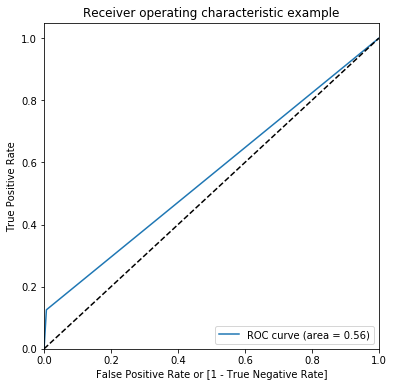

(array([0.        , 0.00693584, 1.        ]),
 array([0.        , 0.12552301, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [53]:
draw_roc(y_pred_final.churn, y_pred_final.predicted)

In [54]:
#draw_roc(y_pred_final.Churn, y_pred_final.predicted)
"{:2.2f}".format(metrics.roc_auc_score(y_pred_final.churn, y_pred_final.Churn_Prob))

'0.88'

#### We see an overall AUC score of 0.88 looks like we did a decent job.
- But we did spend a lot of effort on the features and their selection.
- Can PCA help reduce our effort?

### PCA on the data

#### Note - 
- While computng the principal components, we must not include the entire dataset. Model building is all about doing well on the data we haven't seen yet!
- So we'll calculate the PCs using the train data, and apply them later on the test data

We will need to remove multicollinearity in the data for the PCA to perform really well.

In [55]:
corr = telecom_hv_cust.corr()
corr.loc[:,:] = np.tril(corr, k=-1)
corr = corr.stack()
cols_to_drop = corr[(corr > 0.60) | (corr < -0.60)].sort_values()
cols_to_drop = cols_to_drop.index.to_list()

In [56]:
drop_col_list = []

for cols in cols_to_drop:
    for elem in cols:
        drop_col_list.append(elem)
                 
telecom_hv_cust.drop(drop_col_list, axis=1, inplace=True)
telecom_hv_cust.shape

(28504, 20)

In [57]:
# Putting feature variable to X
X = telecom_hv_cust.drop(['churn','mobile_number'],axis=1)

# Putting response variable to y
y = telecom_hv_cust['churn']

y.head()

7     1
8     0
21    0
23    0
33    0
Name: churn, dtype: int32

In [83]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

# apply SMOTE to correct class imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_tr,y_tr = sm.fit_sample(X_train,y_train)

ImportError: cannot import name '_to_object_array' from 'sklearn.utils' (C:\Users\bipin\Anaconda3\lib\site-packages\sklearn\utils\__init__.py)

In [84]:
# Scaling the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)

NameError: name 'X_tr' is not defined

In [60]:
X_tr.shape

NameError: name 'X_tr' is not defined

In [61]:
from sklearn.decomposition import PCA

In [62]:
pca = PCA(random_state=42)

In [63]:
pca.fit(X_tr)

NameError: name 'X_tr' is not defined

#### Components from the PCA

In [64]:
pca.components_

AttributeError: 'PCA' object has no attribute 'components_'

Looking at the explained variance ratio for each component

In [65]:
pca.explained_variance_ratio_

AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

Making a scree plot for the explained variance

In [66]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

NameError: name 'var_cumu' is not defined

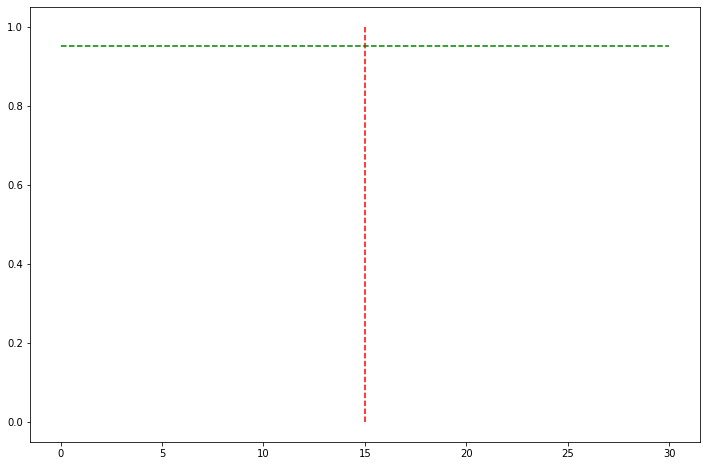

In [67]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=15, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

Perform PCA with 15 components

In [68]:
from sklearn.decomposition import IncrementalPCA

In [69]:
pca_final = IncrementalPCA(n_components=15)

In [70]:
df_train_pca = pca_final.fit_transform(X_tr)

NameError: name 'X_tr' is not defined

In [71]:
df_train_pca.shape

NameError: name 'df_train_pca' is not defined

In [72]:
corrmat = np.corrcoef(df_train_pca.transpose())

NameError: name 'df_train_pca' is not defined

In [73]:
corrmat.shape

NameError: name 'corrmat' is not defined

Plotting the heatmap of the corr matrix

In [74]:
plt.figure(figsize=[15,15])
sns.heatmap(corrmat, annot=True)

<Figure size 1080x1080 with 0 Axes>

NameError: name 'corrmat' is not defined

<Figure size 1080x1080 with 0 Axes>

Applying the transformation on the test set

In [75]:
X_test = scaler.transform(X_test)
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

### Applying logistic regression on the data on our Principal components

In [76]:
from sklearn.linear_model import LogisticRegression

In [77]:
learner_pca = LogisticRegression()

In [78]:
model_pca = learner_pca.fit(df_train_pca, y_tr)

NameError: name 'df_train_pca' is not defined

Making predictions on the test set

In [ ]:
pred_probs_test = model_pca.predict_proba(df_test_pca)

In [ ]:
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test[:,1]))

#### Making it a little more unsupervised 

In [ ]:
pca_again = PCA(0.9)

In [ ]:
df_train_pca2 = pca_again.fit_transform(X_tr)

In [ ]:
df_train_pca2.shape

Following it up with a logistic regression model

In [ ]:
learner_pca2 = LogisticRegression()

In [ ]:
model_pca2 = learner_pca2.fit(df_train_pca2, y_tr)

In [ ]:
df_test_pca2 = pca_again.transform(X_test)

In [ ]:
df_test_pca2.shape

In [ ]:
pred_probs_test2 = model_pca2.predict_proba(df_test_pca2)[:,1]

In [ ]:
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test2))

PCA is great! 

Conclusions from the above model:

Model has 74% Accuracy 13 features can explain 90% variance in the dataset.



## Decision Tree

In [ ]:
# lets create a decision tree now
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

# apply SMOTE to tackle class imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_tr,y_tr = sm.fit_sample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)

skipping standardization because decision tree doesn't require it. It is also not affected too much with multicollinearity

In [ ]:
# feature selection using lasso
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
 
svc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X_tr, y_tr)
svc_model = SelectFromModel(svc, prefit=True)
X_lasso = svc_model.transform(X_tr)
position = svc_model.get_support(indices=True)

print(X_lasso.shape)
print(position)

In [ ]:
# feature vector for decision tree
lasso_features = list(t.columns[position])
print("Lasso Features: ", lasso_features)

In [ ]:
# import decision tree libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# lets create a decision tree with the default hyper parameters except max depth to make the tree readable
dt1 = DecisionTreeClassifier(max_depth=5)
dt1.fit(X_lasso, y_tr)

In [ ]:
# lets see the classification reort of the model built
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Model predictions
X_test = pd.DataFrame(data=X_test).iloc[:, position]
y_pred1 = dt1.predict(X_test)

# classification report
print(classification_report(y_test, y_pred1))

In [ ]:
# confusion matrix
print(confusion_matrix(y_test,y_pred1))
# accuracy of the decision tree
print('Decision Tree - Accuracy :',accuracy_score(y_test,y_pred1))

### FIne tuning the hyper parameters

In [ ]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)
                               
# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

In [ ]:
# grid search results
score = tree.cv_results_
pd.DataFrame(score).head()

In [ ]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(score["param_max_depth"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_max_depth"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Max depth 17 seems to be the best fit ?

In [ ]:
# lets find optimal value of minimum sample leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

In [ ]:
# grid search results
score = tree.cv_results_
pd.DataFrame(score).head()

In [ ]:
# plotting accuracies with min_sample_leaf
plt.figure()
plt.plot(score["param_min_samples_leaf"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_min_samples_leaf"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_sample_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

min_sample_leaf = 50 seems to be the optimal one ?

In [ ]:
# lets fine tune min sample split now
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

In [ ]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

min_samples_leaf=50 seems to be optimal

In [ ]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 20, 5),
    'min_samples_leaf': range(25, 175, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_lasso, y_tr)

In [ ]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results
# printing the optimal accuracy score and hyperparameters
print("Best Accuracy", grid_search.best_score_)

In [ ]:
print(grid_search.best_estimator_)

In [ ]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=15, 
                                  min_samples_leaf=25,
                                  min_samples_split=50)
clf_gini.fit(X_lasso, y_tr)

In [ ]:
# accuracy score
print ('Accuracy Score for Decision Tree Final Model :',clf_gini.score(X_test,y_test))

Conclusion from the above Decision Tree model - 
1. 78% accuracy on the test dataset
2. Precision of the model is very high 98% and recall 64%. This means model might miss predicting some customers as churn but the ones it predicts to be churn will be with high confidence.